In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

'''

    RUMORE CsI + FUNZIONI VARIE
    
'''

rumore = pd.read_csv('CSI-fondo-newgate.CSV', sep=';')

channel_back = np.array(rumore['Channel']) #taglio i dati per avere lo stesso numero di elementi
counts_back = np.array(rumore['Counts'])
time_back = 61638 #s
frequency_back = counts_back/time_back

allungo_x = np.arange(20510, 1000000, 20)
allungo_y = np.zeros(len(allungo_x))
channel_back = np.concatenate((channel_back, allungo_x))
counts_back = np.concatenate((counts_back, allungo_y))
frequency_back = np.concatenate((frequency_back, allungo_y))

def frequency_converter(counts, time_signal=180, frequency_back=frequency_back, time_background=time_back, counts_back=counts_back):
    frequency = counts/time_signal
    counts_back = counts_back [:len(frequency)]
    frequency_ = frequency - frequency_back[:len(frequency)]
    for i in range(len(frequency_)):
        if frequency_[i] < 0:
            frequency_[i] = 0
    error = np.sqrt(counts/time_signal**2 + counts_back/time_background**2)
    return frequency_, error

def SNIP_algorithm(spectrum, iterations=40):
    spectrum_log = np.log(np.log(np.sqrt(spectrum + 1) + 1) + 1)
    n_added = iterations
    begin_list = np.ones(n_added) * spectrum_log[0]
    end_list = np.ones(n_added) * spectrum_log[-1]
    spectrum_log = np.concatenate((begin_list, spectrum_log, end_list))
    for k in range(1, iterations+1, 1):
        for i in range(len(spectrum_log[n_added:-n_added])):
            spectrum_log[i] = np.minimum(spectrum_log[i], 0.5 * (spectrum_log[i+k] + spectrum_log[i-k]))
    return (np.exp(np.exp(spectrum_log[n_added:-n_added])-1)-1)**2-1

# funzioni per fit
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2

def func(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def func2(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * norm.pdf(x, mu1, sigma1) + A2 * norm.pdf(x, mu2, sigma2)

intensità_511KeV = []
intensità_trapz_511KeV = []
err_intensità_511KeV = []
err_sistematico_511KeV = []

intensità_1274_5KeV = []
intensità_trapz_1274_5KeV = []
err_intensità_1274_5KeV = []
err_sistematico_1274_5KeV = []

In [32]:
'''

    ARIA 0cm

'''

segnale_0cm = pd.read_csv('0CM.CSV', sep=';')
channel_0 = np.array(segnale_0cm['Channel'])
counts_0 = np.array(segnale_0cm['Counts'])

# calculating frequency and removing background noise
N = 45
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])


# plot
fig = px.line(x=channel_0, y=frequency_0[0], error_y=frequency_0[1], title='Spettro Na con alluminio di spessore 0cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=20000, mu1=12000, sigma1=400, A2=1800, mu2=10000, sigma2=100)
ls.mask = (channel_0 > 9000) & (channel_0 < 14000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

area_tot = m.values['A1'] + m.values['A2']
err_area_tot = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {area_tot:.2f} ± {err_area_tot:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))


# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=20000, mu1=12000, sigma1=400, A2=1800, mu2=10000, sigma2=100)
ls.mask = (channel_0 > 9000) & (channel_0 < 14000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-1)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=20000, mu1=12000, sigma1=400, A2=1800, mu2=10000, sigma2=100)
ls.mask = (channel_0 > 9000) & (channel_0 < 14000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area_tot:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 429.9 (χ²/ndof = 1.8)      │              Nfcn = 598              │
│ EDM = 1.22e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.69e3   │  0.17e3   │            │            │         │         │       │
│ 1 │ mu1    │ 11.794e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    414    │     9     │            │            │         │         │       │
│ 3 │ A2     │  2.84e3   │  0.17e3   │            │            │         │         │       │
│ 4 │ mu2    │ 11.235e3  │  0.030e3  │            │            │         │         │       │
│ 5 │ sigma2 │    657    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.89e+04  -1.06e3   1.42e3 -0.029e6   -5.0e3     -450 │
│    mu1 │  -1.06e3     87.1      -60   1.04e3      150      -30 │
│ sigma1 │   1.42e3      -60     78.8  -1.41e3     -240      -20 │
│     A2 │ -0.029e6   1.04e3  -1.41e3 2.88e+04    5.0e3      490 │
│    mu2 │   -5.0e3      150     -240    5.0e3      930      120 │
│ sigma2 │     -450      -30      -20      490      120     79.8 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 1859.59
Area picco con integrale fit: 5532.45 ± 240.17


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 438.3 (χ²/ndof = 1.8)      │              Nfcn = 601              │
│ EDM = 5.79e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.73e3   │  0.17e3   │            │            │         │         │       │
│ 1 │ mu1    │ 11.790e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    416    │     9     │            │            │         │         │       │
│ 3 │ A2     │  2.81e3   │  0.17e3   │            │            │         │         │       │
│ 4 │ mu2    │ 11.227e3  │  0.031e3  │            │            │         │         │       │
│ 5 │ sigma2 │    661    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 2.87e+04  -1.06e3   1.40e3 -0.028e6   -5.1e3     -430 │
│    mu1 │  -1.06e3     86.6      -60   1.04e3      150      -30 │
│ sigma1 │   1.40e3      -60       77  -1.39e3     -240      -20 │
│     A2 │ -0.028e6   1.04e3  -1.39e3 2.86e+04    5.1e3      470 │
│    mu2 │   -5.1e3      150     -240    5.1e3      956      120 │
│ sigma2 │     -430      -30      -20      470      120     82.8 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 5542.59


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 425.5 (χ²/ndof = 1.7)      │              Nfcn = 612              │
│ EDM = 8.11e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │  2.66e3   │  0.17e3   │            │            │         │         │       │
│ 1 │ mu1    │ 11.796e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    413    │     9     │            │            │         │         │       │
│ 3 │ A2     │  2.87e3   │  0.17e3   │            │            │         │         │       │
│ 4 │ mu2    │  11.24e3  │  0.03e3   │            │            │         │         │       │
│ 5 │ sigma2 │    655    │     9     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │  2.9e+04  -1.06e3   1.43e3 -0.029e6   -5.0e3     -460 │
│    mu1 │  -1.06e3     87.4      -60   1.04e3      150      -30 │
│ sigma1 │   1.43e3      -60     79.9  -1.43e3     -240      -20 │
│     A2 │ -0.029e6   1.04e3  -1.43e3  2.9e+04    5.0e3      500 │
│    mu2 │   -5.0e3      150     -240    5.0e3      916      120 │
│ sigma2 │     -460      -30      -20      500      120     78.2 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 5523.48
Errore statistico: 240.17
Errore sistematico: 9.55


In [33]:
# fit
N = 60
#60
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=25000, sigma1=400, A2=300, mu2=21000, sigma2=800)
ls.mask = (channel_0 > 20000) & (channel_0 < 27000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_0)):
    if channel_0[i] > integral_extremes[0] and channel_0[i] < integral_extremes[1]:
        freq_integral.append(frequency_0[0][i])
        channel_integral.append(channel_0[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N+2)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=25000, sigma1=400, A2=300, mu2=21000, sigma2=800)
ls.mask = (channel_0 > 20000) & (channel_0 < 27000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0 = frequency_converter(counts_0, time_signal=300)
background_0 = SNIP_algorithm(frequency_0[0], iterations=N-2)
frequency_0 = (frequency_0[0] - background_0, frequency_0[1])

ls = LeastSquares(channel_0, frequency_0[0], frequency_0[1], func2)
m = Minuit(ls, A1=1700, mu1=25000, sigma1=400, A2=300, mu2=21000, sigma2=800)
ls.mask = (channel_0 > 20000) & (channel_0 < 27000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 494 (χ²/ndof = 1.4)        │              Nfcn = 597              │
│ EDM = 1.22e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    343    │     6     │            │            │         │         │       │
│ 1 │ mu1    │ 25.032e3  │  0.019e3  │            │            │         │         │       │
│ 2 │ sigma1 │    789    │    16     │            │            │         │         │       │
│ 3 │ A2     │    730    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  20.33e3  │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.22e3   │  0.06e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     38.3      -40       40      -70      130     -110 │
│    mu1 │      -40      346  -0.16e3   0.29e3  -0.52e3   0.45e3 │
│ sigma1 │       40  -0.16e3      248  -0.25e3   0.44e3  -0.39e3 │
│     A2 │      -70   0.29e3  -0.25e3 2.18e+03   -4.2e3    2.8e3 │
│    mu2 │      130  -0.52e3   0.44e3   -4.2e3  8.8e+03     -6e3 │
│ sigma2 │     -110   0.45e3  -0.39e3    2.8e3     -6e3 4.01e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 1843.08
Area picco con integrale fit: 343.26 ± 6.19


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 495.6 (χ²/ndof = 1.4)      │              Nfcn = 523              │
│ EDM = 0.000113 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    343    │     6     │            │            │         │         │       │
│ 1 │ mu1    │ 25.031e3  │  0.019e3  │            │            │         │         │       │
│ 2 │ sigma1 │    789    │    16     │            │            │         │         │       │
│ 3 │ A2     │    740    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  20.32e3  │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.22e3   │  0.06e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     38.4      -40       40      -70      130     -110 │
│    mu1 │      -40      348  -0.17e3   0.30e3  -0.54e3   0.46e3 │
│ sigma1 │       40  -0.17e3      249  -0.26e3   0.45e3  -0.40e3 │
│     A2 │      -70   0.30e3  -0.26e3 2.24e+03   -4.3e3    2.8e3 │
│    mu2 │      130  -0.54e3   0.45e3   -4.3e3 8.95e+03     -6e3 │
│ sigma2 │     -110   0.46e3  -0.40e3    2.8e3     -6e3 4.06e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 343.48


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 493.7 (χ²/ndof = 1.4)      │              Nfcn = 556              │
│ EDM = 0.000116 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    343    │     6     │            │            │         │         │       │
│ 1 │ mu1    │ 25.032e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    789    │    16     │            │            │         │         │       │
│ 3 │ A2     │    720    │    50     │            │            │         │         │       │
│ 4 │ mu2    │  20.34e3  │  0.09e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.21e3   │  0.06e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     38.1      -40       40      -70      120     -100 │
│    mu1 │      -40      344  -0.16e3   0.28e3  -0.50e3   0.44e3 │
│ sigma1 │       40  -0.16e3      247  -0.24e3   0.43e3  -0.38e3 │
│     A2 │      -70   0.28e3  -0.24e3  2.1e+03   -4.1e3    2.7e3 │
│    mu2 │      120  -0.50e3   0.43e3   -4.1e3 8.63e+03     -5e3 │
│ sigma2 │     -100   0.44e3  -0.38e3    2.7e3     -5e3 3.96e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 343.01
Errore statistico: 6.17
Errore sistematico: 0.23


In [34]:
'''

    ARIA 0.4cm

'''

segnale_0_4cm = pd.read_csv('0.4CM(Time 1942).CSV', sep='\t')
channel_0_4 = np.array(segnale_0cm['Channel'])
counts_0_4 = np.array(segnale_0_4cm['Counts'])

# calculating frequency and removing background noise
N = 40
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

# plot
fig = px.line(x=channel_0_4, y=frequency_0_4[0], error_y=frequency_0_4[1], title='Spettro Na con alluminio di spessore 0.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=20000, mu1=14000, sigma1=400, A2=1800, mu2=13000, sigma2=100)
ls.mask = (channel_0 > 12000) & (channel_0 < 16000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_0_4)):
    if channel_0_4[i] > integral_extremes[0] and channel_0_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_0_4[0][i])
        channel_integral.append(channel_0_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N+1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=20000, mu1=14000, sigma1=400, A2=1800, mu2=13000, sigma2=100)
ls.mask = (channel_0 > 12000) & (channel_0 < 16000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N-1)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=20000, mu1=14000, sigma1=400, A2=1800, mu2=13000, sigma2=100)
ls.mask = (channel_0 > 12000) & (channel_0 < 16000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 280.8 (χ²/ndof = 1.4)      │              Nfcn = 751              │
│ EDM = 1.14e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    970    │    60     │            │            │         │         │       │
│ 1 │ mu1    │ 14.628e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    462    │     7     │            │            │         │         │       │
│ 3 │ A2     │  1.28e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ mu2    │ 13.994e3  │  0.027e3  │            │            │         │         │       │
│ 5 │ sigma2 │    658    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 4.16e+03     -460      450     -4e3   -1.7e3     -380 │
│    mu1 │     -460     84.1      -60      450      170       20 │
│ sigma1 │      450      -60     54.3     -440     -180      -30 │
│     A2 │     -4e3      450     -440 4.18e+03    1.7e3      380 │
│    mu2 │   -1.7e3      170     -180    1.7e3      752      180 │
│ sigma2 │     -380       20      -30      380      180     60.6 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 506.86
Area picco con integrale fit: 973.68 ± 64.50


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 285.8 (χ²/ndof = 1.5)      │              Nfcn = 776              │
│ EDM = 3.11e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    980    │    60     │            │            │         │         │       │
│ 1 │ mu1    │ 14.626e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    463    │     7     │            │            │         │         │       │
│ 3 │ A2     │  1.28e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ mu2    │ 13.992e3  │  0.027e3  │            │            │         │         │       │
│ 5 │ sigma2 │    660    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 4.13e+03     -450      440     -4e3   -1.7e3     -370 │
│    mu1 │     -450     83.5      -60      450      170       20 │
│ sigma1 │      440      -60       54     -440     -180      -30 │
│     A2 │     -4e3      450     -440 4.15e+03    1.7e3      380 │
│    mu2 │   -1.7e3      170     -180    1.7e3      748      170 │
│ sigma2 │     -370       20      -30      380      170       60 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 2259.63


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 277.4 (χ²/ndof = 1.4)      │              Nfcn = 759              │
│ EDM = 3.85e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    970    │    60     │            │            │         │         │       │
│ 1 │ mu1    │ 14.630e3  │  0.009e3  │            │            │         │         │       │
│ 2 │ sigma1 │    461    │     7     │            │            │         │         │       │
│ 3 │ A2     │  1.28e3   │  0.06e3   │            │            │         │         │       │
│ 4 │ mu2    │ 13.996e3  │  0.028e3  │            │            │         │         │       │
│ 5 │ sigma2 │    656    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │ 4.19e+03     -460      450     -4e3   -1.8e3     -390 │
│    mu1 │     -460       85      -60      460      170       20 │
│ sigma1 │      450      -60     54.8     -450     -180      -40 │
│     A2 │     -4e3      460     -450 4.21e+03    1.8e3      390 │
│    mu2 │   -1.8e3      170     -180    1.8e3      756      180 │
│ sigma2 │     -390       20      -40      390      180     61.4 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 2249.31
Errore statistico: 64.76
Errore sistematico: 5.16


In [35]:
# fit
N = 35
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_0_4 > 24500) & (channel_0_4 < 32500)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_0_4)):
    if channel_0_4[i] > integral_extremes[0] and channel_0_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_0_4[0][i])
        channel_integral.append(channel_0_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N+2)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_0_4 > 24500) & (channel_0_4 < 32500)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_0_4 = frequency_converter(counts_0_4, time_signal=1942)
background_0_4 = SNIP_algorithm(frequency_0_4[0], iterations=N-2)
frequency_0_4 = (frequency_0_4[0] - background_0_4, frequency_0_4[1])

ls = LeastSquares(channel_0_4, frequency_0_4[0], frequency_0_4[1], func2)
m = Minuit(ls, A1=800, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_0_4 > 24500) & (channel_0_4 < 32500)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 768.4 (χ²/ndof = 2.0)      │              Nfcn = 630              │
│ EDM = 8.23e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   149.3   │    1.5    │            │            │         │         │       │
│ 1 │ mu1    │ 30.247e3  │  0.011e3  │            │            │         │         │       │
│ 2 │ sigma1 │    880    │     8     │            │            │         │         │       │
│ 3 │ A2     │    182    │     5     │            │            │         │         │       │
│ 4 │ mu2    │  25.17e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.094e3  │  0.031e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.24     -3.6      3.4     -0.6      3.5     -4.3 │
│    mu1 │     -3.6      127      -50        8  -0.05e3   0.06e3 │
│ sigma1 │      3.4      -50     70.5       -7       40      -50 │
│     A2 │     -0.6        8       -7     28.1     -188      141 │
│    mu2 │      3.5  -0.05e3       40     -188 1.69e+03   -1.1e3 │
│ sigma2 │     -4.3   0.06e3      -50      141   -1.1e3      953 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 484.20
Area picco con integrale fit: 149.29 ± 1.50


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 781.4 (χ²/ndof = 2.0)      │              Nfcn = 575              │
│ EDM = 1.03e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   152.0   │    1.5    │            │            │         │         │       │
│ 1 │ mu1    │ 30.242e3  │  0.011e3  │            │            │         │         │       │
│ 2 │ sigma1 │    883    │     8     │            │            │         │         │       │
│ 3 │ A2     │    190    │     5     │            │            │         │         │       │
│ 4 │ mu2    │  25.16e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.094e3  │  0.030e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.24     -3.5      3.3     -0.6      3.4     -4.1 │
│    mu1 │     -3.5      123      -50        8  -0.04e3   0.06e3 │
│ sigma1 │      3.3      -50       68       -7       40      -50 │
│     A2 │     -0.6        8       -7     28.7     -185      137 │
│    mu2 │      3.4  -0.04e3       40     -185 1.59e+03   -1.0e3 │
│ sigma2 │     -4.1   0.06e3      -50      137   -1.0e3      878 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 151.99


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 749.3 (χ²/ndof = 1.9)      │              Nfcn = 576              │
│ EDM = 6.27e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   145.3   │    1.5    │            │            │         │         │       │
│ 1 │ mu1    │ 30.254e3  │  0.012e3  │            │            │         │         │       │
│ 2 │ sigma1 │    874    │     9     │            │            │         │         │       │
│ 3 │ A2     │    173    │     5     │            │            │         │         │       │
│ 4 │ mu2    │  25.18e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.095e3  │  0.033e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │     2.24     -3.8      3.6     -0.6      3.7     -4.5 │
│    mu1 │     -3.8      133      -50        8  -0.05e3   0.06e3 │
│ sigma1 │      3.6      -50     74.3       -7       40      -50 │
│     A2 │     -0.6        8       -7     27.7     -194      147 │
│    mu2 │      3.7  -0.05e3       40     -194 1.83e+03   -1.2e3 │
│ sigma2 │     -4.5   0.06e3      -50      147   -1.2e3 1.05e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 145.35
Errore statistico: 1.50
Errore sistematico: 3.32


In [36]:
'''

    ARIA 1cm

'''

segnale_1cm = pd.read_csv('1.0CM(Time 2560).CSV', sep='\t')
channel_1 = np.array(segnale_0cm['Channel'])
counts_1 = np.array(segnale_1cm['Counts'])

# calculating frequency and removing background noise
N = 42
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N)

frequency_1 = (frequency_1[0] - background_1, frequency_1[1])


# plot
fig = px.line(x=channel_1, y=frequency_1[0], error_y=frequency_1[1], title='Spettro Na con alluminio di spessore 1cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=100, mu2=13000, sigma2=50)
ls.mask = (channel_1 > 12000) & (channel_1 < 16000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N+1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=100, mu2=13000, sigma2=50)
ls.mask = (channel_1 > 12000) & (channel_1 < 16000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N-1)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=100, mu2=13000, sigma2=50)
ls.mask = (channel_1 > 12000) & (channel_1 < 16000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 235 (χ²/ndof = 1.2)        │              Nfcn = 785              │
│ EDM = 5.99e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    168    │    20     │            │            │         │         │       │
│ 1 │ mu1    │ 14.639e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    392    │    17     │            │            │         │         │       │
│ 3 │ A2     │    701    │    20     │            │            │         │         │       │
│ 4 │ mu2    │ 14.078e3  │  0.015e3  │            │            │         │         │       │
│ 5 │ sigma2 │    657    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     385 -0.17e3  0.32e3  -0.4e3 -0.29e3     -37 │
│    mu1 │ -0.17e3     210 -0.16e3  0.17e3  0.10e3     -18 │
│ sigma1 │  0.32e3 -0.16e3     290 -0.32e3 -0.23e3     -29 │
│     A2 │  -0.4e3  0.17e3 -0.32e3     395  0.29e3      39 │
│    mu2 │ -0.29e3  0.10e3 -0.23e3  0.29e3     226      35 │
│ sigma2 │     -37     -18     -29      39      35    18.6 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 196.13
Area picco con integrale fit: 167.80 ± 19.62


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 236.9 (χ²/ndof = 1.2)      │              Nfcn = 805              │
│ EDM = 7.18e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    169    │    20     │            │            │         │         │       │
│ 1 │ mu1    │ 14.637e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    393    │    17     │            │            │         │         │       │
│ 3 │ A2     │    700    │    20     │            │            │         │         │       │
│ 4 │ mu2    │ 14.077e3  │  0.015e3  │            │            │         │         │       │
│ 5 │ sigma2 │    658    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     389 -0.18e3  0.32e3  -0.4e3 -0.29e3     -36 │
│    mu1 │ -0.18e3     211 -0.16e3  0.18e3  0.10e3     -18 │
│ sigma1 │  0.32e3 -0.16e3     288 -0.32e3 -0.23e3     -29 │
│     A2 │  -0.4e3  0.18e3 -0.32e3     400  0.29e3      39 │
│    mu2 │ -0.29e3  0.10e3 -0.23e3  0.29e3     228      35 │
│ sigma2 │     -36     -18     -29      39      35    18.7 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 869.67


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 232.6 (χ²/ndof = 1.2)      │              Nfcn = 819              │
│ EDM = 1.21e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    167    │    20     │            │            │         │         │       │
│ 1 │ mu1    │ 14.640e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    391    │    17     │            │            │         │         │       │
│ 3 │ A2     │    701    │    20     │            │            │         │         │       │
│ 4 │ mu2    │ 14.079e3  │  0.015e3  │            │            │         │         │       │
│ 5 │ sigma2 │    656    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │     382 -0.17e3  0.32e3  -0.4e3 -0.28e3     -37 │
│    mu1 │ -0.17e3     209 -0.16e3  0.17e3  0.10e3     -17 │
│ sigma1 │  0.32e3 -0.16e3     290 -0.32e3 -0.23e3     -30 │
│     A2 │  -0.4e3  0.17e3 -0.32e3     392  0.29e3      40 │
│    mu2 │ -0.28e3  0.10e3 -0.23e3  0.29e3     226      35 │
│ sigma2 │     -37     -17     -30      40      35    18.7 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 867.33
Errore statistico: 19.54
Errore sistematico: 1.17


In [37]:
# fit 
N = 35
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=400, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_1 > 24000) & (channel_1 < 31900)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_1)):
    if channel_1[i] > integral_extremes[0] and channel_1[i] < integral_extremes[1]:
        freq_integral.append(frequency_1[0][i])
        channel_integral.append(channel_1[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N+2)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=400, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_1 > 24000) & (channel_1 < 31900)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1 = frequency_converter(counts_1, time_signal=2560)
background_1 = SNIP_algorithm(frequency_1[0], iterations=N-2)
frequency_1 = (frequency_1[0] - background_1, frequency_1[1])

ls = LeastSquares(channel_1, frequency_1[0], frequency_1[1], func2)
m = Minuit(ls, A1=400, mu1=30000, sigma1=400, A2=400, mu2=25000, sigma2=600)
ls.mask = (channel_1 > 24000) & (channel_1 < 31900)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 586.2 (χ²/ndof = 1.5)      │              Nfcn = 401              │
│ EDM = 8.81e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   62.7    │    0.8    │            │            │         │         │       │
│ 1 │ mu1    │ 29.988e3  │  0.015e3  │            │            │         │         │       │
│ 2 │ sigma1 │    951    │    12     │            │            │         │         │       │
│ 3 │ A2     │   78.7    │    2.2    │            │            │         │         │       │
│ 4 │ mu2    │  24.89e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.135e3  │  0.032e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.695     -1.7      3.1     -0.2      2.0     -3.3 │
│    mu1 │     -1.7      218  -0.04e3        4  -0.05e3   0.08e3 │
│ sigma1 │      3.1  -0.04e3      155       -5   0.05e3  -0.09e3 │
│     A2 │     -0.2        4       -5     4.95      -75       57 │
│    mu2 │      2.0  -0.05e3   0.05e3      -75 1.84e+03   -1.1e3 │
│ sigma2 │     -3.3   0.08e3  -0.09e3       57   -1.1e3 1.02e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 232.00
Area picco con integrale fit: 62.68 ± 0.83


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 593.6 (χ²/ndof = 1.5)      │              Nfcn = 390              │
│ EDM = 4.62e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   63.7    │    0.8    │            │            │         │         │       │
│ 1 │ mu1    │ 29.987e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    953    │    12     │            │            │         │         │       │
│ 3 │ A2     │   82.2    │    2.3    │            │            │         │         │       │
│ 4 │ mu2    │  24.87e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.137e3  │  0.031e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.695     -1.6      3.1     -0.2      1.9     -3.2 │
│    mu1 │     -1.6      211  -0.04e3        4  -0.05e3   0.08e3 │
│ sigma1 │      3.1  -0.04e3      150       -5   0.05e3  -0.08e3 │
│     A2 │     -0.2        4       -5     5.09      -74       56 │
│    mu2 │      1.9  -0.05e3   0.05e3      -74 1.74e+03   -1.0e3 │
│ sigma2 │     -3.2   0.08e3  -0.08e3       56   -1.0e3      955 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 63.69


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 580 (χ²/ndof = 1.5)        │              Nfcn = 407              │
│ EDM = 2.17e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   61.2    │    0.8    │            │            │         │         │       │
│ 1 │ mu1    │ 29.991e3  │  0.015e3  │            │            │         │         │       │
│ 2 │ sigma1 │    948    │    13     │            │            │         │         │       │
│ 3 │ A2     │   74.9    │    2.2    │            │            │         │         │       │
│ 4 │ mu2    │  24.90e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.134e3  │  0.033e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.695     -1.8      3.2     -0.2      2.1     -3.5 │
│    mu1 │     -1.8      227  -0.05e3        4  -0.05e3   0.09e3 │
│ sigma1 │      3.2  -0.05e3      162       -5   0.05e3  -0.09e3 │
│     A2 │     -0.2        4       -5     4.81      -76       58 │
│    mu2 │      2.1  -0.05e3   0.05e3      -76 1.97e+03   -1.2e3 │
│ sigma2 │     -3.5   0.09e3  -0.09e3       58   -1.2e3 1.11e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 61.21
Errore statistico: 0.83
Errore sistematico: 1.24


In [38]:
'''

    ARIA 1.4cm

'''

segnale_1_4cm = pd.read_csv('1.4CM(Time 3534).CSV', sep='\t')
channel_1_4 = np.array(segnale_0cm['Channel'])
counts_1_4 = np.array(segnale_1_4cm['Counts'])

# calculating frequency and removing background noise
N = 43
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])


# plot
fig = px.line(x=channel_1_4, y=frequency_1_4[0], error_y=frequency_1_4[1], title='Spettro Na con alluminio di spessore 1.4cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_1_4 > 12000) & (channel_1_4 < 16000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_1_4)):
    if channel_1_4[i] > integral_extremes[0] and channel_1_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_1_4[0][i])
        channel_integral.append(channel_1_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N+1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_1_4 > 12000) & (channel_1_4 < 16000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N-1)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_1_4 > 12000) & (channel_1_4 < 16000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 198.6 (χ²/ndof = 1.0)      │              Nfcn = 769              │
│ EDM = 3.98e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    67     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.598e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    341    │    17     │            │            │         │         │       │
│ 3 │ A2     │    462    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.979e3  │  0.011e3  │            │            │         │         │       │
│ 5 │ sigma2 │    635    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │      64     -50     130     -60     -80     -19 │
│    mu1 │     -50     204 -0.13e3      50  0.05e3     -13 │
│ sigma1 │     130 -0.13e3     298    -130 -0.16e3     -37 │
│     A2 │     -60      50    -130    68.7      90      20 │
│    mu2 │     -80  0.05e3 -0.16e3      90     120      29 │
│ sigma2 │     -19     -13     -37      20      29    16.7 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 130.36
Area picco con integrale fit: 67.50 ± 8.00


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 199.1 (χ²/ndof = 1.0)      │              Nfcn = 772              │
│ EDM = 1.59e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    68     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.598e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    342    │    17     │            │            │         │         │       │
│ 3 │ A2     │    462    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.979e3  │  0.011e3  │            │            │         │         │       │
│ 5 │ sigma2 │    636    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    63.5     -50     130     -60     -80     -19 │
│    mu1 │     -50     205 -0.13e3      50  0.05e3     -13 │
│ sigma1 │     130 -0.13e3     296    -130 -0.16e3     -36 │
│     A2 │     -60      50    -130    68.2      80      20 │
│    mu2 │     -80  0.05e3 -0.16e3      80     119      28 │
│ sigma2 │     -19     -13     -36      20      28    16.5 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 529.84


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 198.1 (χ²/ndof = 1.0)      │              Nfcn = 767              │
│ EDM = 2.09e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    68     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.599e3  │  0.014e3  │            │            │         │         │       │
│ 2 │ sigma1 │    342    │    17     │            │            │         │         │       │
│ 3 │ A2     │    461    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.978e3  │  0.011e3  │            │            │         │         │       │
│ 5 │ sigma2 │    634    │     4     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    65.5     -50     130     -70     -90     -20 │
│    mu1 │     -50     203 -0.13e3      50  0.05e3     -13 │
│ sigma1 │     130 -0.13e3     301    -130 -0.16e3     -38 │
│     A2 │     -70      50    -130    70.3      90      21 │
│    mu2 │     -90  0.05e3 -0.16e3      90     124      30 │
│ sigma2 │     -20     -13     -38      21      30    17.1 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 528.83
Errore statistico: 8.10
Errore sistematico: 0.50


In [39]:
# fit
N = 35
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_1_4 > 23000) & (channel_1_4 < 32000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_1_4)):
    if channel_1_4[i] > integral_extremes[0] and channel_1_4[i] < integral_extremes[1]:
        freq_integral.append(frequency_1_4[0][i])
        channel_integral.append(channel_1_4[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N+2)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_1_4 > 23000) & (channel_1_4 < 32000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_1_4 = frequency_converter(counts_1_4, time_signal=3534)
background_1_4 = SNIP_algorithm(frequency_1_4[0], iterations=N-2)
frequency_1_4 = (frequency_1_4[0] - background_1_4, frequency_1_4[1])

ls = LeastSquares(channel_1_4, frequency_1_4[0], frequency_1_4[1], func2)
m = Minuit(ls, A1=190, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_1_4 > 23000) & (channel_1_4 < 32000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 580.8 (χ²/ndof = 1.3)      │             Nfcn = 1044              │
│ EDM = 5.01e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   38.3    │    0.5    │            │            │         │         │       │
│ 1 │ mu1    │ 29.703e3  │  0.016e3  │            │            │         │         │       │
│ 2 │ sigma1 │    932    │    11     │            │            │         │         │       │
│ 3 │ A2     │   59.1    │    1.3    │            │            │         │         │       │
│ 4 │ mu2    │  24.36e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.350e3  │  0.033e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      0.3    -1.62     1.62    -0.08     0.98    -2.68 │
│    mu1 │    -1.62      252  -0.06e3      3.4  -0.04e3   0.12e3 │
│ sigma1 │     1.62  -0.06e3      131     -2.5   0.03e3  -0.09e3 │
│     A2 │    -0.08      3.4     -2.5     1.74    -34.3     30.7 │
│    mu2 │     0.98  -0.04e3   0.03e3    -34.3 1.58e+03   -0.9e3 │
│ sigma2 │    -2.68   0.12e3  -0.09e3     30.7   -0.9e3 1.06e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 159.69
Area picco con integrale fit: 38.28 ± 0.55


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5564 (χ²/ndof = 12.5)      │              Nfcn = 197              │
│ EDM = 2.93e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   40.0    │    0.5    │            │            │         │         │       │
│ 1 │ mu1    │ 29.646e3  │  0.002e3  │            │            │         │         │       │
│ 2 │ sigma1 │   981.5   │    2.0    │            │            │         │         │       │
│ 3 │ A2     │   61.1    │    2.0    │            │            │         │         │       │
│ 4 │ mu2    │ 17.6998e3 │ 0.0020e3  │            │            │         │         │       │
│ 5 │ sigma2 │   882.1   │    2.0    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────┐
│        │     A1    mu1 sigma1     A2    mu2 sigma2 │
├────────┼───────────────────────────────────────────┤
│     A1 │  0.265  -0.01   0.03  -0.00  -0.00   0.00 │
│    mu1 │  -0.01   3.93     -0     -0     -0      0 │
│ sigma1 │   0.03     -0   3.88      0      0      0 │
│     A2 │  -0.00     -0      0      4      0      0 │
│    mu2 │  -0.00     -0      0      0      4      0 │
│ sigma2 │   0.00      0      0      0      0      4 │
└────────┴───────────────────────────────────────────┘

Area picco con integrale fit: 40.02


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 571.1 (χ²/ndof = 1.3)      │              Nfcn = 600              │
│ EDM = 2.18e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   37.4    │    0.5    │            │            │         │         │       │
│ 1 │ mu1    │ 29.703e3  │  0.016e3  │            │            │         │         │       │
│ 2 │ sigma1 │    930    │    12     │            │            │         │         │       │
│ 3 │ A2     │   55.9    │    1.3    │            │            │         │         │       │
│ 4 │ mu2    │  24.39e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.346e3  │  0.034e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │      0.3    -1.67     1.68    -0.08     0.99    -2.81 │
│    mu1 │    -1.67      264  -0.07e3      3.4  -0.04e3   0.13e3 │
│ sigma1 │     1.68  -0.07e3      137     -2.6   0.03e3  -0.09e3 │
│     A2 │    -0.08      3.4     -2.6     1.69    -34.5     31.2 │
│    mu2 │     0.99  -0.04e3   0.03e3    -34.5 1.69e+03   -0.9e3 │
│ sigma2 │    -2.81   0.13e3  -0.09e3     31.2   -0.9e3 1.15e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 37.42
Errore statistico: 0.55
Errore sistematico: 1.30


In [40]:
'''

    ARIA 2cm

'''

segnale_2cm = pd.read_csv('2.0CM(Time 3705).CSV', sep='\t')
channel_2 = np.array(segnale_0cm['Channel'])
counts_2 = np.array(segnale_2cm['Counts'])

# calculating frequency and removing background noise
N = 44
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])


# plot
fig = px.line(x=channel_2, y=frequency_2[0], error_y=frequency_2[1], title='Spettro Na con alluminio di spessore 2cm', labels={'x':'Canale', 'y':'Frequenza [Hz]'})
fig.show()


# fit
ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_2 > 12000) & (channel_2 < 16000)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [1600, 2600]
for i in range(len(channel_2)):
    if channel_2[i] > integral_extremes[0] and channel_2[i] < integral_extremes[1]:
        freq_integral.append(frequency_2[0][i])
        channel_integral.append(channel_2[i])

area = m.values['A1'] + m.values['A2']
err_area = np.sqrt(m.errors['A1']**2 + m.errors['A2']**2)

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {area:.2f} ± {err_area:.2f}')

intensità_511KeV.append(m.values['A1']+m.values['A2'])
intensità_trapz_511KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_511KeV.append(np.sqrt(m.errors['A1']**2+m.errors['A2']**2))

# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N+1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_2 > 12000) & (channel_2 < 16000)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N-1)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=2000, mu1=14000, sigma1=200, A2=40, mu2=13000, sigma2=30)
ls.mask = (channel_2 > 12000) & (channel_2 < 16000)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1'] + m.values['A2']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_511KeV.append(err_sistematico)
print(f'Errore statistico: {err_area:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 218.7 (χ²/ndof = 1.1)      │              Nfcn = 863              │
│ EDM = 9.54e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    41     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.657e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    352    │    24     │            │            │         │         │       │
│ 3 │ A2     │    279    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.977e3  │  0.019e3  │            │            │         │         │       │
│ 5 │ sigma2 │    627    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    61.4     -70     180     -60    -150     -50 │
│    mu1 │     -70     325 -0.24e3      70  0.13e3      10 │
│ sigma1 │     180 -0.24e3     598    -180  -0.4e3    -140 │
│     A2 │     -60      70    -180    65.5     150      50 │
│    mu2 │    -150  0.13e3  -0.4e3     150     360     130 │
│ sigma2 │     -50      10    -140      50     130    58.9 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 82.26
Area picco con integrale fit: 319.66 ± 11.26


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 218.6 (χ²/ndof = 1.1)      │              Nfcn = 830              │
│ EDM = 1.11e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    41     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.657e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    352    │    24     │            │            │         │         │       │
│ 3 │ A2     │    279    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.977e3  │  0.019e3  │            │            │         │         │       │
│ 5 │ sigma2 │    628    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    60.6     -70     180     -60    -140     -50 │
│    mu1 │     -70     324 -0.24e3      70  0.13e3      10 │
│ sigma1 │     180 -0.24e3     596    -180  -0.4e3    -140 │
│     A2 │     -60      70    -180    64.6     150      50 │
│    mu2 │    -140  0.13e3  -0.4e3     150     355     120 │
│ sigma2 │     -50      10    -140      50     120    58.1 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 319.80


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 219.4 (χ²/ndof = 1.1)      │              Nfcn = 827              │
│ EDM = 9.33e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │    41     │     8     │            │            │         │         │       │
│ 1 │ mu1    │ 14.658e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    352    │    24     │            │            │         │         │       │
│ 3 │ A2     │    279    │     8     │            │            │         │         │       │
│ 4 │ mu2    │ 13.977e3  │  0.019e3  │            │            │         │         │       │
│ 5 │ sigma2 │    627    │     8     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────┐
│        │      A1     mu1  sigma1      A2     mu2  sigma2 │
├────────┼─────────────────────────────────────────────────┤
│     A1 │    61.8     -70     180     -60    -150     -50 │
│    mu1 │     -70     326 -0.25e3      70  0.14e3      10 │
│ sigma1 │     180 -0.25e3     599    -180  -0.4e3    -140 │
│     A2 │     -60      70    -180    65.8     150      50 │
│    mu2 │    -150  0.14e3  -0.4e3     150     363     130 │
│ sigma2 │     -50      10    -140      50     130    59.3 │
└────────┴─────────────────────────────────────────────────┘

Area picco con integrale fit: 319.48
Errore statistico: 11.26
Errore sistematico: 0.16


In [41]:
# fit
N = 35
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=650, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_2 > 22000) & (channel_2 < 31900)
m.migrad()
m.hesse()
display(m)

freq_integral = []
channel_integral = []
integral_extremes = [4800, 5700]
for i in range(len(channel_2)):
    if channel_2[i] > integral_extremes[0] and channel_2[i] < integral_extremes[1]:
        freq_integral.append(frequency_2[0][i])
        channel_integral.append(channel_2[i])

print(f'Area picco con integrale trapezoidale: {np.trapz(freq_integral, channel_integral):.2f}')
print(f'Area picco con integrale fit: {m.values["A1"]:.2f} ± {m.errors["A1"]:.2f}')

intensità_1274_5KeV.append(m.values['A1'])
intensità_trapz_1274_5KeV.append(np.trapz(freq_integral, channel_integral))
err_intensità_1274_5KeV.append(m.errors['A1'])

# calcolo errore sistematico DOWN
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N+2)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=650, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_2 > 22000) & (channel_2 < 31900)
m.migrad()
m.hesse()
display(m)

area_down = m.values['A1']
print(f'Area picco con integrale fit: {area_down:.2f}')

# calcolo errore sistematico UP
frequency_2 = frequency_converter(counts_2, time_signal=3705)
background_2 = SNIP_algorithm(frequency_2[0], iterations=N-2)
frequency_2 = (frequency_2[0] - background_2, frequency_2[1])

ls = LeastSquares(channel_2, frequency_2[0], frequency_2[1], func2)
m = Minuit(ls, A1=650, mu1=30000, sigma1=400, A2=300, mu2=24000, sigma2=600)
ls.mask = (channel_2 > 22000) & (channel_2 < 31900)
m.migrad()
m.hesse()
display(m)

area_up = m.values['A1']
print(f'Area picco con integrale fit: {area_up:.2f}')

err_sistematico = abs(area_up - area_down)/2
err_sistematico_1274_5KeV.append(err_sistematico)
print(f'Errore statistico: {m.errors["A1"]:.2f}')
print(f'Errore sistematico: {err_sistematico:.2f}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 618.6 (χ²/ndof = 1.3)      │              Nfcn = 528              │
│ EDM = 1.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   25.0    │    0.4    │            │            │         │         │       │
│ 1 │ mu1    │ 29.695e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    933    │    13     │            │            │         │         │       │
│ 3 │ A2     │   42.6    │    0.9    │            │            │         │         │       │
│ 4 │ mu2    │  24.07e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.55e3   │  0.04e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.177    -1.36     1.42    -0.04     0.35    -2.68 │
│    mu1 │    -1.36      339  -0.07e3      2.6  -0.02e3   0.17e3 │
│ sigma1 │     1.42  -0.07e3      177     -1.9   0.01e3  -0.12e3 │
│     A2 │    -0.04      2.6     -1.9    0.761    -16.8     18.5 │
│    mu2 │     0.35  -0.02e3   0.01e3    -16.8 1.63e+03   -0.8e3 │
│ sigma2 │    -2.68   0.17e3  -0.12e3     18.5   -0.8e3 1.29e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale trapezoidale: 94.32
Area picco con integrale fit: 24.97 ± 0.42


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 622.7 (χ²/ndof = 1.3)      │              Nfcn = 526              │
│ EDM = 2.4e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   25.3    │    0.4    │            │            │         │         │       │
│ 1 │ mu1    │ 29.696e3  │  0.018e3  │            │            │         │         │       │
│ 2 │ sigma1 │    932    │    13     │            │            │         │         │       │
│ 3 │ A2     │   44.7    │    0.9    │            │            │         │         │       │
│ 4 │ mu2    │  24.05e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.554e3  │  0.035e3  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.177    -1.34     1.39    -0.04     0.37    -2.57 │
│    mu1 │    -1.34      329  -0.07e3      2.6  -0.02e3   0.16e3 │
│ sigma1 │     1.39  -0.07e3      172     -1.9   0.01e3  -0.11e3 │
│     A2 │    -0.04      2.6     -1.9    0.775    -16.7     18.1 │
│    mu2 │     0.37  -0.02e3   0.01e3    -16.7 1.53e+03   -0.8e3 │
│ sigma2 │    -2.57   0.16e3  -0.11e3     18.1   -0.8e3  1.2e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 25.27


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 609 (χ²/ndof = 1.2)        │              Nfcn = 524              │
│ EDM = 2.18e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A1     │   24.5    │    0.4    │            │            │         │         │       │
│ 1 │ mu1    │ 29.695e3  │  0.019e3  │            │            │         │         │       │
│ 2 │ sigma1 │    933    │    14     │            │            │         │         │       │
│ 3 │ A2     │   40.5    │    0.9    │            │            │         │         │       │
│ 4 │ mu2    │  24.08e3  │  0.04e3   │            │            │         │         │       │
│ 5 │ sigma2 │  1.54e3   │  0.04e3   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────┐
│        │       A1      mu1   sigma1       A2      mu2   sigma2 │
├────────┼───────────────────────────────────────────────────────┤
│     A1 │    0.178    -1.41     1.46    -0.04     0.35    -2.83 │
│    mu1 │    -1.41      353  -0.08e3      2.7  -0.02e3   0.18e3 │
│ sigma1 │     1.46  -0.08e3      185     -2.0   0.01e3  -0.13e3 │
│     A2 │    -0.04      2.7     -2.0    0.751    -17.2     19.0 │
│    mu2 │     0.35  -0.02e3   0.01e3    -17.2 1.76e+03   -0.9e3 │
│ sigma2 │    -2.83   0.18e3  -0.13e3     19.0   -0.9e3 1.41e+03 │
└────────┴───────────────────────────────────────────────────────┘

Area picco con integrale fit: 24.50
Errore statistico: 0.42
Errore sistematico: 0.38


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.879 (χ²/ndof = 1.6)      │              Nfcn = 69               │
│ EDM = 2.8e-06 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │  2.21e3   │  0.06e3   │            │            │         │         │       │
│ 1 │ B    │   0.571   │   0.019   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        A        B │
├───┼───────────────────┤
│ A │ 4.09e+03  1.04592 │
│ B │  1.04592  0.00035 │
└───┴───────────────────┘

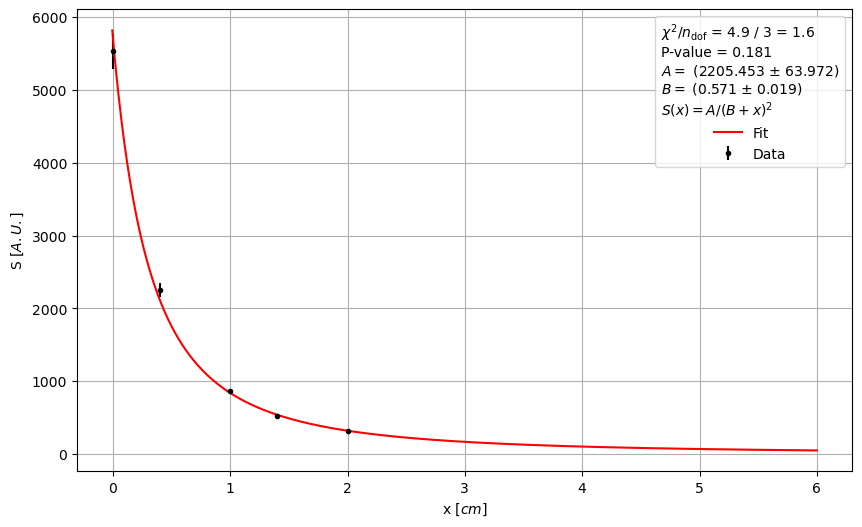

Intensità: [5532.45406023 2255.08136718  868.63860222  529.39621238  319.66194131]
Intensità err: [240.3637637   91.46297081  27.95021429  11.53289073  11.26463695]
Spessori: [0.  0.4 1.  1.4 2. ]

 Intensità trapezi: [1859.5911038629029, 506.8617266594478, 196.12635969621638, 130.35641260971903, 82.26253655269957]


In [42]:
'''

    FIT ASSORBIMENTO con 511KeV con mu=0

'''

def angolo_solido_func(x, A, B):
    return (A/(B+(x+0.05))**2)

spessori = np.array([0., 0.4, 1, 1.4, 2])
intensità = np.array(intensità_511KeV)
intensità_err = np.sqrt(np.array(err_intensità_511KeV)**2 + np.array(err_sistematico_511KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, angolo_solido_func)
m = Minuit(ls, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = angolo_solido_func(x_axis, m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.xlabel('x $[cm]$')
plt.ylabel('S $[A.U.]$')
plt.show()
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'\n Intensità trapezi: {intensità_trapz_511KeV}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.893 (χ²/ndof = 1.4)      │              Nfcn = 136              │
│ EDM = 4.5e-08 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.09    │   0.06    │            │            │         │         │       │
│ 1 │ A    │   2.7e3   │   0.4e3   │            │            │         │         │       │
│ 2 │ B    │   0.64    │   0.06    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │       mu        A        B │
├────┼────────────────────────────┤
│ mu │  0.00416   24.834   0.0035 │
│  A │   24.834 1.55e+05  22.6628 │
│  B │   0.0035  22.6628  0.00346 │
└────┴────────────────────────────┘

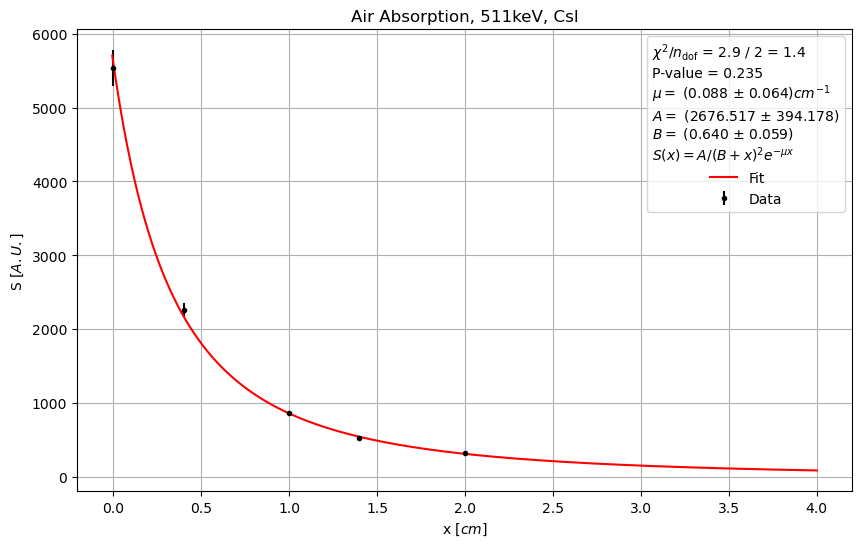

Coefficiente di assorbimento: 0.0884 ± 0.0645
Intensità: [5532.45406023 2255.08136718  868.63860222  529.39621238  319.66194131]
Intensità err: [240.3637637   91.46297081  27.95021429  11.53289073  11.26463695]
Spessori: [0.  0.4 1.  1.4 2. ]

 Intensità trapezi: [1859.5911038629029, 506.8617266594478, 196.12635969621638, 130.35641260971903, 82.26253655269957]
Compatibilità con zero: 1.37 sigma


In [43]:
'''

    FIT ASSORBIMENTO con 511KeV con mu

'''

def assorbimento(x, mu, A, B):
    return (A/(B+(x+0.05))**2) * np.exp(-mu * x)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.0001, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Air Absorption, 511keV, CsI')
plt.xlabel('x $[cm]$')
plt.ylabel('S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'\n Intensità trapezi: {intensità_trapz_511KeV}')
print(f'Compatibilità con zero: {m.values["mu"]/m.errors["mu"]:.2f} sigma')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.333 (χ²/ndof = 1.8)      │              Nfcn = 110              │
│ EDM = 7.69e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A    │    186    │     4     │            │            │         │         │       │
│ 1 │ B    │   0.683   │   0.013   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        A        B │
├───┼───────────────────┤
│ A │     19.7 50.76e-3 │
│ B │ 50.76e-3 0.000162 │
└───┴───────────────────┘

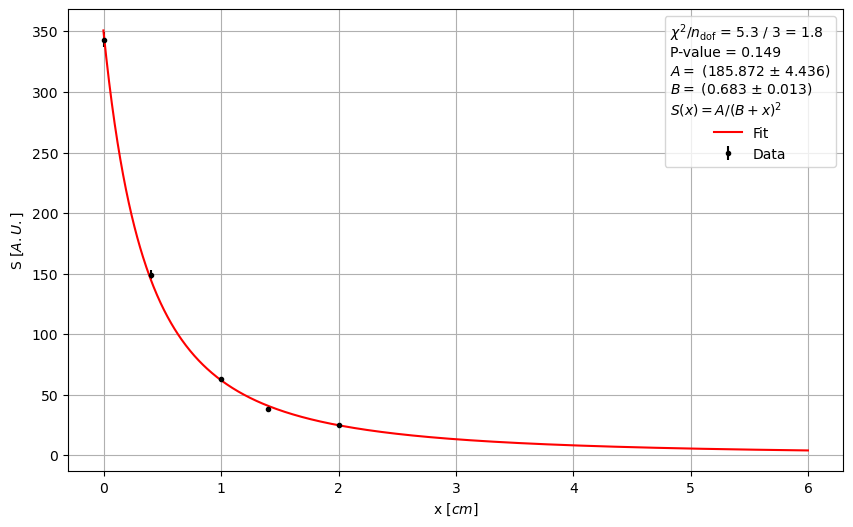

Intensità: [343.26277497 149.28995945  62.68367756  38.28356423  24.96862066]
Intensità err: [6.1915094  3.64067887 1.49331068 1.41126426 0.56768694]
Spessori: [0.  0.4 1.  1.4 2. ]


In [44]:
'''

    FIT ASSORBIMENTO con 1274.5KeV con mu=0

'''

intensità = np.array(intensità_1274_5KeV)
intensità_err = np.sqrt(np.array(err_intensità_1274_5KeV)**2 + np.array(err_sistematico_1274_5KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, angolo_solido_func)
m = Minuit(ls, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 6, 1000)
y = angolo_solido_func(x_axis, m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.xlabel('x $[cm]$')
plt.ylabel('S $[A.U.]$')
plt.show()
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.685 (χ²/ndof = 2.3)      │              Nfcn = 189              │
│ EDM = 2.85e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu   │   0.03    │   0.04    │            │            │         │         │       │
│ 1 │ A    │    201    │    20     │            │            │         │         │       │
│ 2 │ B    │   0.71    │   0.04    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────┐
│    │      mu       A       B │
├────┼─────────────────────────┤
│ mu │ 0.00176  0.8200  0.0016 │
│  A │  0.8200     406  0.8232 │
│  B │  0.0016  0.8232 0.00171 │
└────┴─────────────────────────┘

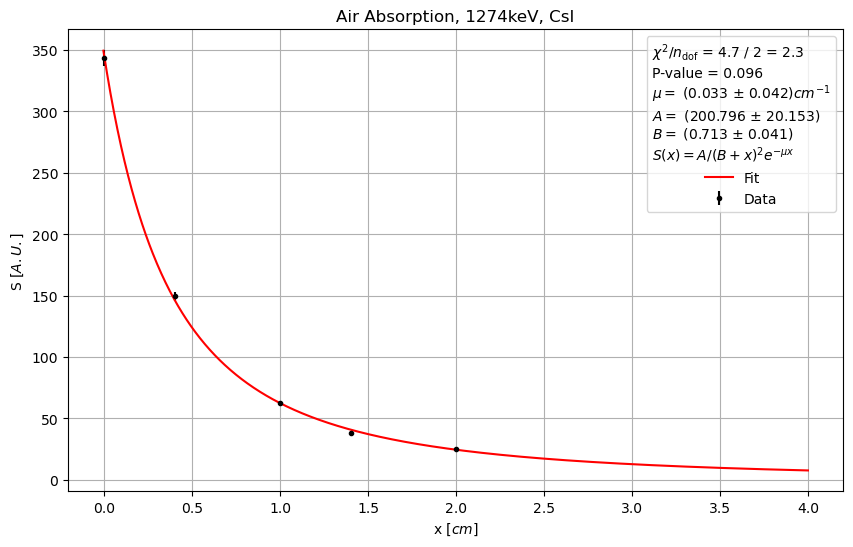

Coefficiente di assorbimento: 0.0335 ± 0.0420
Intensità: [343.26277497 149.28995945  62.68367756  38.28356423  24.96862066]
Intensità err: [6.1915094  3.64067887 1.49331068 1.41126426 0.56768694]
Spessori: [0.  0.4 1.  1.4 2. ]
Compatibilità con zero: 0.80 sigma


In [45]:
'''

    FIT ASSORBIMENTO con 1274.5KeV

'''

intensità = np.array(intensità_1274_5KeV)
intensità_err = np.sqrt(np.array(err_intensità_1274_5KeV)**2 + np.array(err_sistematico_1274_5KeV)**2)

ls = LeastSquares(spessori, intensità, intensità_err, assorbimento)
m = Minuit(ls, mu=0.001, A=4000, B=0.75)
m.migrad()
m.hesse()
display(m)

# plot
x_axis = np.linspace(-0.005, 4, 1000)
y = assorbimento(x_axis, m.values['mu'], m.values['A'], m.values['B'])
plt.subplots(figsize=(10, 6))
plt.errorbar(spessori, intensità, intensità_err, marker='.', linestyle='', color='black', label='Data', ecolor='black')
plt.plot(x_axis, y, color='red', label='Fit')
fit_info = [f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {(m.fval/m.ndof):.1f}",]
p_value = (1. - chi2.cdf(m.fval, df=m.ndof))
fit_info.append(f"P-value = {p_value:.3f}")
fit_info.append(f'$\\mu = $ ({m.values["mu"]:.3f} $\\pm$ {m.errors["mu"]:.3f})' + '$cm^{-1}$')
fit_info.append(f'$A = $ ({m.values["A"]:.3f} $\\pm$ {m.errors["A"]:.3f})')
fit_info.append(f'$B = $ ({m.values["B"]:.3f} $\\pm$ {m.errors["B"]:.3f})')
fit_info.append('$S(x) = A/(B+x)^2 e^{- \mu x}$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.grid(True)
plt.title('Air Absorption, 1274keV, CsI')
plt.xlabel('x $[cm]$')
plt.ylabel('S $[A.U.]$')
plt.show()
print(f'Coefficiente di assorbimento: {m.values["mu"]:.4f} ± {m.errors["mu"]:.4f}')
print(f'Intensità: {intensità}')
print(f'Intensità err: {intensità_err}')
print(f'Spessori: {spessori}')
print(f'Compatibilità con zero: {m.values["mu"]/m.errors["mu"]:.2f} sigma')